In [1]:
# archivo test_clean.csv
import pandas as pd
try:
    df = pd.read_csv('../data/test_clean.csv')
    print("Info del archivo test_clean.csv:")
    print(df.info())
    print("\nPrimeras filas:")
    print(df.head())
    if 'label' in df.columns:
        print("\nValores únicos en 'label':")
        print(df['label'].value_counts(dropna=False))
except Exception as e:
    print(f"Error al leer test_clean.csv: {e}")

Info del archivo test_clean.csv:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7027943 entries, 0 to 7027942
Data columns (total 16 columns):
 #   Column             Dtype  
---  ------             -----  
 0   user_id            int64  
 1   age_range          int64  
 2   gender             int64  
 3   merchant_id        int64  
 4   label              float64
 5   activity_len       int64  
 6   actions_0          int64  
 7   actions_2          int64  
 8   actions_3          int64  
 9   unique_items       int64  
 10  unique_categories  int64  
 11  unique_brands      int64  
 12  date_min           object 
 13  date_max           object 
 14  day_span           int64  
 15  has_1111           int64  
dtypes: float64(1), int64(13), object(2)
memory usage: 857.9+ MB
None

Primeras filas:
   user_id  age_range  gender  merchant_id  label  activity_len  actions_0  \
0   163968          0       0         4378   -1.0             1          1   
1   163968          0       0      

=== Tabla resumida ===


,PR_AUC,F1,notes
model,,,
lightgbm_baseline,0.126196,0.189745,LightGBM baseline
xgboost_grid,0.120312,0.247788,"XGBoost (grid_search, umbral óptimo)"
rf_optimized,0.105600,0.205900,RandomForest (optimizado)


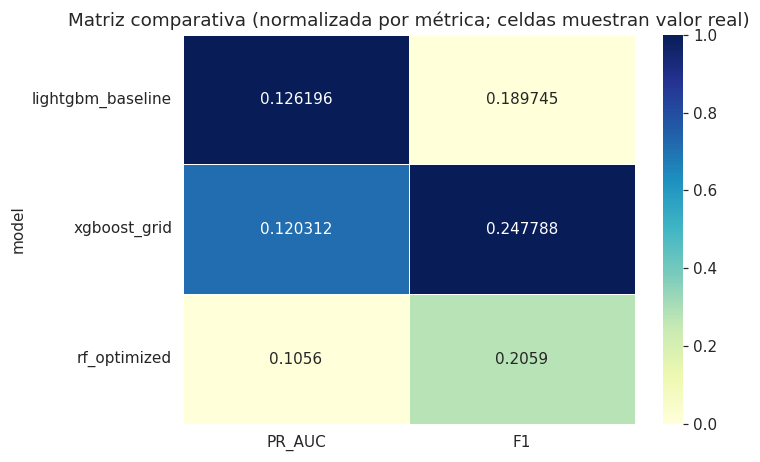

/tmp/ipykernel_749428/2477243999.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=metric, y="model", data=plot_df.sort_values(metric, ascending=False), palette=pal_list)


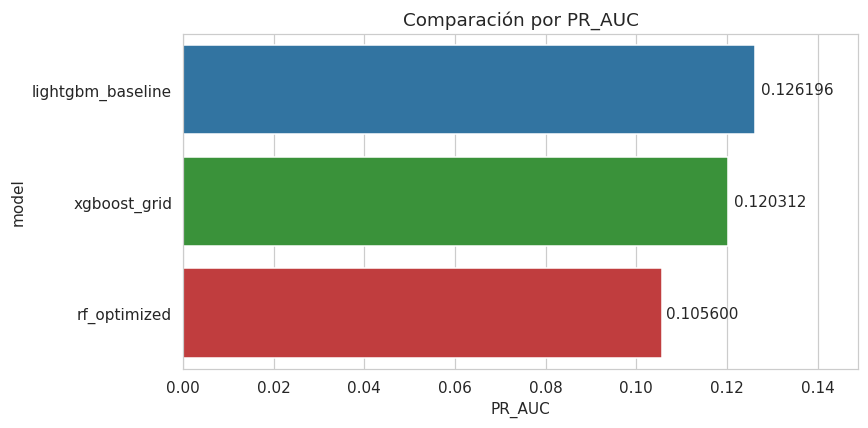

/tmp/ipykernel_749428/2477243999.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=metric, y="model", data=plot_df.sort_values(metric, ascending=False), palette=pal_list)


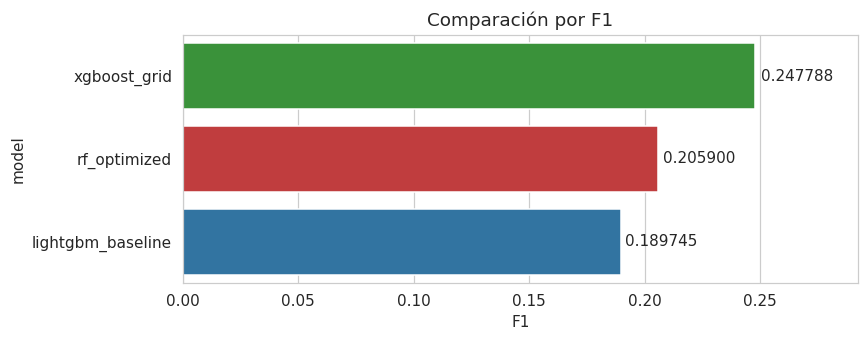

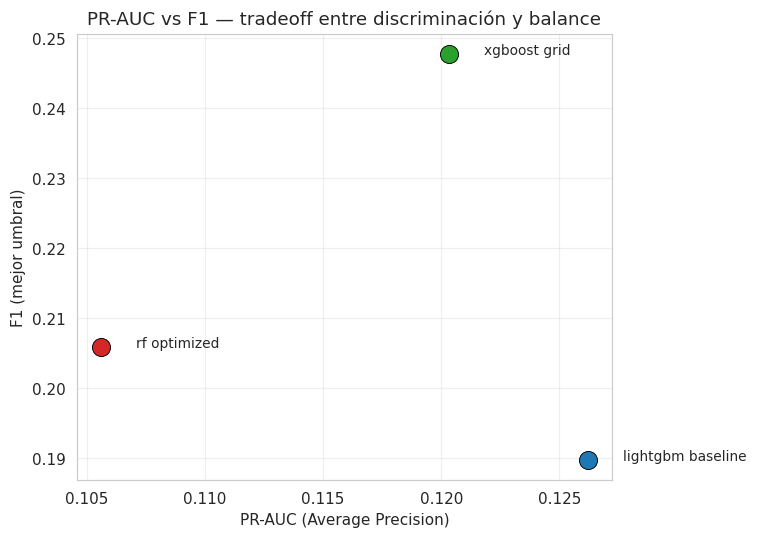

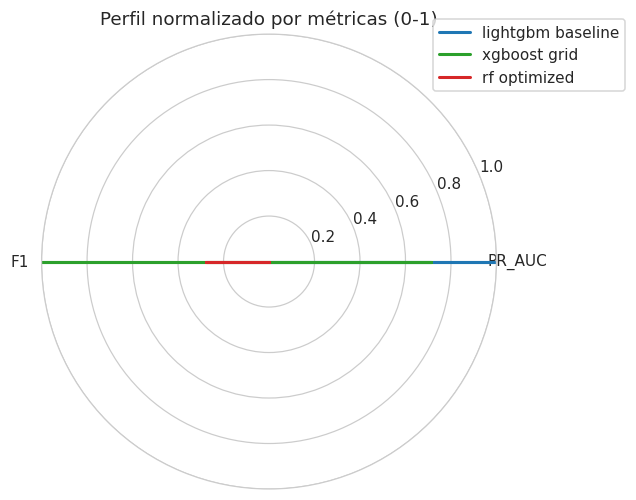

In [2]:
# Celda unica: visualizaciones comparativas (PR-AUC / F1) con colores consistentes por modelo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams["figure.dpi"] = 110

# --- 1) Datos ---
rows = [
    {"model":"lightgbm_baseline", "PR_AUC": 0.126196, "F1": 0.189745, "notes":"LightGBM baseline"},
    {"model":"xgboost_grid",       "PR_AUC": 0.120312, "F1": 0.247788, "notes":"XGBoost (grid_search, umbral óptimo)"},
    {"model":"rf_optimized",       "PR_AUC": 0.105600, "F1": 0.205900, "notes":"RandomForest (optimizado)"}
]
df = pd.DataFrame(rows).set_index("model")

# --- Color map consistente: ajusta hex si prefieres otros tonos ---
color_map = {
    "lightgbm_baseline": "#1f77b4",  # azul
    "xgboost_grid":       "#2ca02c",  # verde
    "rf_optimized":       "#d62728"   # rojo
}
# fallback color
default_color = "#7f7f7f"

# --- 2) Tabla resumen (ordenada por PR_AUC) ---
df_sorted = df.sort_values("PR_AUC", ascending=False)
print("=== Tabla resumida ===")
display(df_sorted.style.format({"PR_AUC":"{:.6f}","F1":"{:.6f}"}))

# --- 3) Heatmap normalizado por columna (min-max) ---
metrics = ["PR_AUC","F1"]
hm = df_sorted[metrics].copy()
# Normalizar 0-1 por columna para color; evitar división por cero
denom = (hm.max() - hm.min()).replace(0, 1)
hm_norm = (hm - hm.min()) / denom
hm_norm = hm_norm.fillna(0)

plt.figure(figsize=(7, 0.9 * len(hm_norm) + 1.6))
sns.heatmap(hm_norm, annot=hm.round(6), fmt="", cmap="YlGnBu", cbar=True, linewidths=0.6)
plt.title("Matriz comparativa (normalizada por métrica; celdas muestran valor real)")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# --- 4) Barras: PR_AUC y F1 (por separado) con colores consistentes ---
for metric, height in [("PR_AUC", 4.0), ("F1", 3.2)]:
    plt.figure(figsize=(8, height))
    plot_df = df_sorted[[metric]].reset_index()
    # construir palette ordenada que seaborn acepta: lista de colores en el orden de plot_df['model']
    pal_list = [color_map.get(m, default_color) for m in plot_df.sort_values(metric, ascending=False)['model'].values]
    ax = sns.barplot(x=metric, y="model", data=plot_df.sort_values(metric, ascending=False), palette=pal_list)
    plt.title(f"Comparación por {metric}")
    # Anotar valores al final de cada barra
    sorted_vals = plot_df.sort_values(metric, ascending=False)[metric].values
    for i, val in enumerate(sorted_vals):
        ax.text(val + max(1e-6, val*0.01), i, f"{val:.6f}", va="center")
    plt.xlim(0, plot_df[metric].max() * 1.18)
    plt.tight_layout()
    plt.show()

# --- 5) Scatter PR_AUC vs F1 (muestra tradeoff) con colores consistentes ---
plt.figure(figsize=(7,5))
x = df_sorted["PR_AUC"].values
y = df_sorted["F1"].values
models = df_sorted.index.tolist()
for i, m in enumerate(models):
    c = color_map.get(m, default_color)
    plt.scatter(x[i], y[i], s=140, color=c, edgecolor='k', linewidth=0.6)
    plt.text(x[i] + 0.0015, y[i], m.replace("_"," "), fontsize=9)
plt.xlabel("PR-AUC (Average Precision)")
plt.ylabel("F1 (mejor umbral)")
plt.title("PR-AUC vs F1 — tradeoff entre discriminación y balance")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# --- 6) Radar (spider) normalizado: usar mismos colores ---
vals = hm_norm.values
labels = metrics
N = len(labels)
angles = np.linspace(0, 2*np.pi, N, endpoint=False).tolist()
angles += angles[:1]  # cerrar
plt.figure(figsize=(6,6))
ax = plt.subplot(111, polar=True)
for i, model in enumerate(hm_norm.index):
    data = hm_norm.loc[model].values.tolist()
    data += data[:1]
    c = color_map.get(model, default_color)
    ax.plot(angles, data, label=model.replace("_"," "), color=c, linewidth=2)
    ax.fill(angles, data, alpha=0.15, color=c)
ax.set_thetagrids(np.degrees(angles[:-1]), labels)
ax.set_ylim(0,1)
ax.set_title("Perfil normalizado por métricas (0-1)")
ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1.05))
plt.tight_layout()
plt.show()


# Recomendaciones de uso por escenario

- Producción (alta precisión y estabilidad): usar el modelo con `scale_pos_weight` y ajustar umbral en validación para cumplir restricciones de precisión/recall del negocio. Monitorizar drift y rendimiento por segmento.

- Campañas de marketing / recall-first (priorizar recuperar más positivos): usar modelos sobre-muestreados (SMOTE/ADASYN) o bajar umbral; evaluar coste de falsos positivos y usar A/B testing.

- Detección conservadora (evitar falsos positivos): incrementar umbral y priorizar precisión; posiblemente combinar con reglas heurísticas.

- Experimentación (nuevos features / configuración): probar focal loss o búsquedas amplias de hiperparámetros (RandomizedSearchCV) en muestras controladas; validar con PR-AUC y curvas PR.

Operaciones y monitoreo:
- Guardar métricas por día/por versión (PR-AUC, F1 a umbral operativo, precision@k).
- Alertas automáticas si PR-AUC cae más de X% o si la prevalencia de la clase positiva cambia significativamente.

/usr/lib/python3.10/pickle.py:1718: UserWarning: [20:18:51] WARNING: /workspace/src/collective/../data/../common/error_msg.h:82: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  setstate(state)
/tmp/ipykernel_749428/3833568108.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=fi_df, palette='viridis')


Loaded model best_xgb_model from ./saved_models/XGBoost/best_xgb_model.joblib
Loaded model best_xgb_model from ./saved_models/XGBoost/best_xgb_model.joblib
FEATURES inferidos desde ../data/train_clean.csv


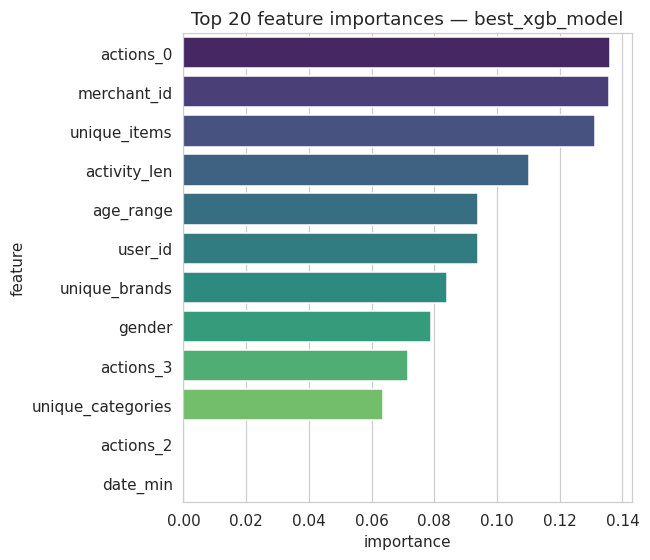

Saved feature importances for best_xgb_model to ./saved_models/analysis/fi_best_xgb_model.png
Feature importance analysis completed.


In [ ]:
# Análisis de Feature Importances por modelo (robusto)
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import joblib
import pickle
sns.set_style('whitegrid')


def analyze_feature_importances(models, feature_names, top_n=20, outdir='./saved_models/analysis'):
    os.makedirs(outdir, exist_ok=True)
    reports = {}
    for name, model in models.items():
        try:
            model_for_fi = getattr(model, 'named_steps', {}).get('xgb', model)
            if not hasattr(model_for_fi, 'feature_importances_'):
                print(f"{name}: no tiene attribute 'feature_importances_'")
                continue
            fi = model_for_fi.feature_importances_
            # asegurar misma longitud
            if len(fi) != len(feature_names):
                print(f"Warning: longitud de feature_importances_ ({len(fi)}) != len(feature_names) ({len(feature_names)}) para {name}. Intentando truncar o rellenar.")
                minlen = min(len(fi), len(feature_names))
                fi = fi[:minlen]
                feature_names_proc = feature_names[:minlen]
            else:
                feature_names_proc = feature_names
            fi_df = pd.DataFrame({'feature': feature_names_proc, 'importance': fi})
            fi_df = fi_df.sort_values('importance', ascending=False).head(top_n)

            plt.figure(figsize=(6, min(0.35*len(fi_df)+1, 8)))
            sns.barplot(x='importance', y='feature', data=fi_df, palette='viridis')
            plt.title(f'Top {top_n} feature importances — {name}')
            plt.tight_layout()
            out_path = os.path.join(outdir, f'fi_{name}.png')
            plt.savefig(out_path, dpi=150, bbox_inches='tight')
            plt.show()
            reports[name] = fi_df
            print(f'Saved feature importances for {name} to {out_path}')
        except Exception as e:
            print(f'Error al procesar {name}: {e}')
    return reports


# Recolectar candidatos (intentar desde variables en memoria y archivo joblib)
candidates = {}
for key in ['best_grid','best_rand','pipe_smote','pipe_adasyn','pipe_spw','baseline_pipeline','best_model']:
    if key in globals():
        candidates[key] = globals()[key]

# Intentar cargar modelo guardado
possible_paths = ['./saved_models', './models', './']
for p in possible_paths:
    for f in glob.glob(os.path.join(p, '**', '*xgb*.joblib'), recursive=True):
        try:
            name = os.path.splitext(os.path.basename(f))[0]
            candidates[name] = joblib.load(f)
            print(f'Loaded model {name} from {f}')
        except Exception as e:
            print(f'Could not load {f}: {e}')

# Si aún no hay candidatos, buscar cualquier joblib/pkl
if not candidates:
    for p in possible_paths:
        for f in glob.glob(os.path.join(p, '**', '*.joblib'), recursive=True):
            try:
                name = os.path.splitext(os.path.basename(f))[0]
                candidates[name] = joblib.load(f)
                print(f'Loaded model {name} from {f}')
            except Exception as e:
                pass
        for f in glob.glob(os.path.join(p, '**', '*.pkl'), recursive=True):
            try:
                name = os.path.splitext(os.path.basename(f))[0]
                with open(f, 'rb') as fh:
                    candidates[name] = pickle.load(fh)
                print(f'Loaded model {name} from {f}')
            except Exception:
                pass

# Resolver nombres de features
feature_names = None
if 'X_train' in globals():
    try:
        feature_names = list(X_train.columns)
    except Exception:
        feature_names = None
elif 'FEATURES' in globals():
    feature_names = FEATURES
else:
    # intentar inferir desde CSV
    try:
        tmp = pd.read_csv('../data/train_clean.csv', nrows=5)
        exclude = set(['label','target','id','customer_id','index'])
        feature_names = [c for c in tmp.columns if c not in exclude]
        print('FEATURES inferidos desde ../data/train_clean.csv')
    except Exception as e:
        print('No se pudieron inferir FEATURES automáticamente:', e)
        feature_names = None

if not candidates:
    print('No se encontraron modelos candidatos en el namespace ni en disco. Ejecuta el entrenamiento o carga los modelos.')
elif feature_names is None:
    print('No se encontraron nombres de features en el namespace. Asegúrate de tener X_train o FEATURES o un train_clean.csv accesible.')
else:
    fi_reports = analyze_feature_importances(candidates, feature_names)
    # Guardar reportes concatenados
    for m, df in fi_reports.items():
        df.to_csv(f'./saved_models/analysis/fi_{m}.csv', index=False)
    print('Feature importance analysis completed.')